In [12]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import h5py

In [2]:
def simulate_fidelity_variance(T, mu1=1.65, sigma1=1, mu2=-1.65, sigma2=1, n=1000, M=1000):
    # Generate all samples for both distributions at once
    samples1 = np.random.normal(mu1, sigma1, (M, n))  # M x n array
    samples2 = np.random.normal(mu2, sigma2, (M, n))  # M x n array

    # Compute sample means and standard deviations
    hat_mu1 = np.mean(samples1, axis=1)  # M means for distribution 1
    hat_sigma1 = np.std(samples1, axis=1, ddof=1)  # M std devs for distribution 1
    
    hat_mu2 = np.mean(samples2, axis=1)  # M means for distribution 2
    hat_sigma2 = np.std(samples2, axis=1, ddof=1)  # M std devs for distribution 2
    
    # Compute Phi(T) for all distributions at once
    Phi1_T = stats.norm.cdf(T, loc=hat_mu1, scale=hat_sigma1)  # M values for distribution 1
    Phi2_T = stats.norm.cdf(T, loc=hat_mu2, scale=hat_sigma2)  # M values for distribution 2

    # Compute variances
    var_Phi1 = np.var(Phi1_T, ddof=1)
    var_Phi2 = np.var(Phi2_T, ddof=1)
    
    # Compute final estimate
    result = 0.5 * (var_Phi1 + var_Phi2)
    return result

target_std = 0.01
target_var = target_std**2

# Example usage
n_test = np.geomspace(10,10000).astype(int)
# print(n_test)
estimated_var = []
T_fixed = 0  # Change this as needed

for i in n_test:
    estimated_var_integral = simulate_fidelity_variance(T_fixed, n = i) 
    estimated_var.append(estimated_var_integral)


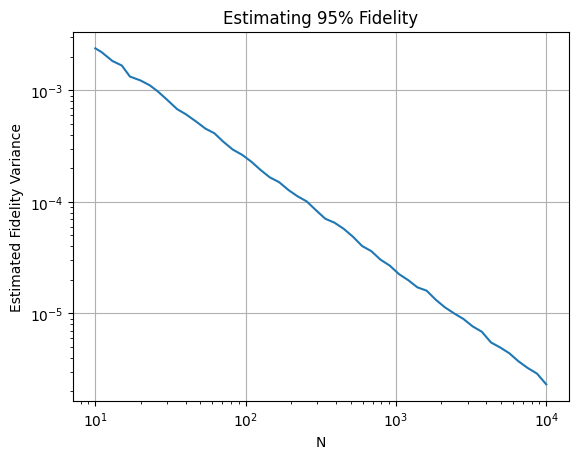

In [3]:
plt.plot(n_test,estimated_var)
plt.title("Estimating 95% Fidelity")
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.xlabel("N") 
plt.ylabel("Estimated Fidelity Variance")
plt.show()

In [7]:
F_required = np.linspace(0.8,0.99,25)
Phi_z = 1 - F_required
mu2 = stats.norm.ppf(Phi_z)  # Inverse CDF (percent point function)

# Example usage
n_test = np.geomspace(10,100000,50).astype(int)
T_fixed = 0

save_variance = []

for i in range(len(mu2)):
    estimated_var = []
    for j in n_test:
        estimated_var_integral = simulate_fidelity_variance(T_fixed, mu1=-mu2[i], mu2=mu2[i], n = j)
        estimated_var.append(estimated_var_integral)

    save_variance.append(estimated_var)

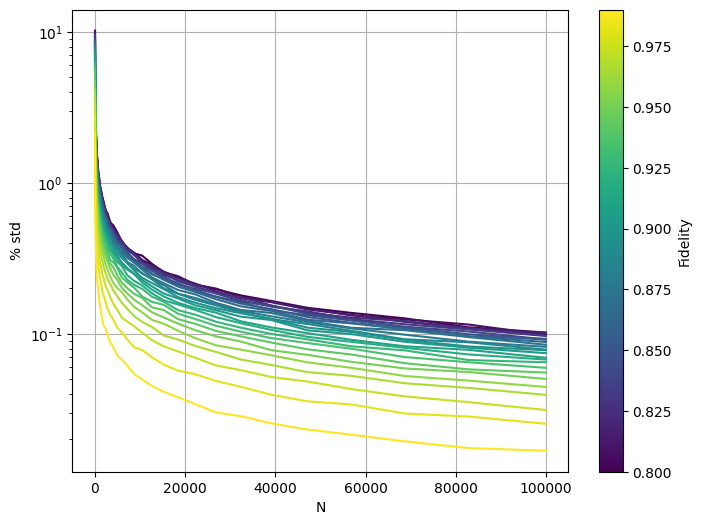

In [8]:
# Create colormap normalization
norm = mcolors.Normalize(vmin=min(F_required), vmax=max(F_required))
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(8, 6))  # Explicitly create an axis

for variance, fidelity in zip(save_variance, F_required):
    color = cmap(norm(fidelity))  # Get color from colormap
    ax.plot(n_test, np.sqrt(variance) * 100, color=color)

ax.set_yscale("log")
ax.grid()
ax.set_xlabel("N")
ax.set_ylabel("% std")

# Create colorbar with correct mapping
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(None)  # Properly initialize ScalarMappable
cbar = fig.colorbar(sm, ax=ax)  # Associate colorbar with the axis
cbar.set_label("Fidelity")

plt.show()


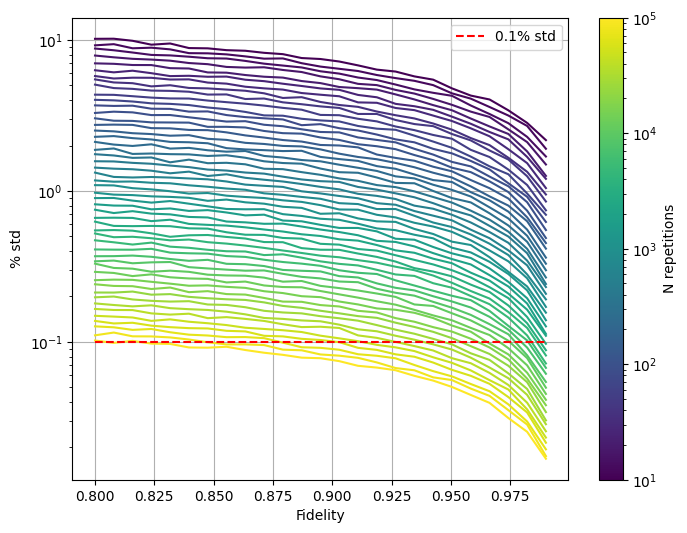

In [9]:
save_variance = np.array(save_variance)

# Normalize n_test values for colormap
norm = mcolors.LogNorm(vmin=np.min(n_test), vmax=np.max(n_test))
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(n_test)):
    color = cmap(norm(n_test[i]))  # Assign color based on n_test value
    ax.plot(F_required, np.sqrt(save_variance[:, i]) * 100, color=color)

ax.set_yscale("log")
ax.hlines(0.1, np.min(F_required), np.max(F_required), linestyle="dashed", color='red', label="0.1% std")
ax.grid()
ax.set_xlabel("Fidelity")
ax.set_ylabel("% std")

# Create colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(None)
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("N repetitions")
plt.legend()
plt.show()

In [14]:
# Open (or create) an HDF5 file
with h5py.File('simulated_fidelity_variance_data.h5', 'w') as f:
    # Save the arrays to the HDF5 file
    f.create_dataset('n_test', data=n_test)
    f.create_dataset('save_variance', data=save_variance)
    f.create_dataset('F_required', data=F_required)

print("Data saved to 'data.h5'.")    

Data saved to 'data.h5'.


In [15]:
try:
    with h5py.File('simulated_fidelity_variance_data.h5', 'r') as f:
        print("File opened successfully!")
        print("Available datasets:", list(f.keys()))
except Exception as e:
    print("Error opening file:", e)

File opened successfully!
Available datasets: ['F_required', 'n_test', 'save_variance']
